# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('btc.csv', parse_dates=True,
                 index_col=0).drop(columns=['Open', 'High', 'Low', 'Volume', 'Currency'])
df

,Close
Date,
2020-06-01,1.01893
2020-06-02,0.95276
2020-06-03,0.96672
2020-06-04,0.97944
2020-06-05,0.96312
...,...
2022-05-28,2.90271
2022-05-29,2.94652
2022-05-30,3.17233


In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_close = df['Close'].values.reshape(-1, 1)
df.head()

df

,Close,Timestamp
Date,,
2020-06-01,1.01893,1.590970e+09
2020-06-02,0.95276,1.591056e+09
2020-06-03,0.96672,1.591142e+09
2020-06-04,0.97944,1.591229e+09
2020-06-05,0.96312,1.591315e+09
...,...,...
2022-05-28,2.90271,1.653696e+09
2022-05-29,2.94652,1.653782e+09
2022-05-30,3.17233,1.653869e+09


## Chuẩn hóa dữ liệu

In [4]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = LR_sc.fit_transform(df_close)
df_scaled

,Close,Timestamp
Date,,
2020-06-01,-1.526877,1.590970e+09
2020-06-02,-1.566503,1.591056e+09
2020-06-03,-1.558143,1.591142e+09
2020-06-04,-1.550526,1.591229e+09
2020-06-05,-1.560299,1.591315e+09
...,...,...
2022-05-28,-0.398775,1.653696e+09
2022-05-29,-0.372539,1.653782e+09
2022-05-30,-0.237313,1.653869e+09


## Vẽ đồ thị

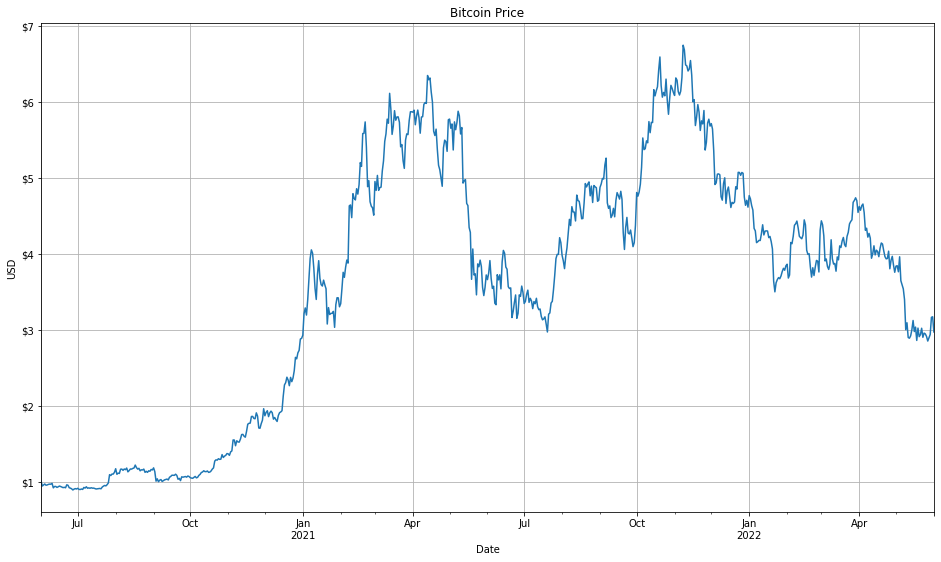

In [5]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [6]:
df

,Close,Timestamp
Date,,
2020-06-01,1.01893,1.590970e+09
2020-06-02,0.95276,1.591056e+09
2020-06-03,0.96672,1.591142e+09
2020-06-04,0.97944,1.591229e+09
2020-06-05,0.96312,1.591315e+09
...,...,...
2022-05-28,2.90271,1.653696e+09
2022-05-29,2.94652,1.653782e+09
2022-05-30,3.17233,1.653869e+09


## Chuẩn hóa dữ liệu

In [7]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Close'] = y_scaled
df_scaled.head()


,Timestamp,Close
Date,,
2020-06-01,-1.729683,-1.526877
2020-06-02,-1.724944,-1.566503
2020-06-03,-1.720205,-1.558143
2020-06-04,-1.715466,-1.550526
2020-06-05,-1.710728,-1.560299


## Chia tập dữ liệu

In [8]:
interrupt = int(len(df_scaled) * .7)
interrupt


511

In [9]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(511, 2)
(220, 2)


In [10]:
train_data.tail()

,Timestamp,Close
Date,,
2021-10-20,0.668179,1.814097
2021-10-21,0.672918,1.588396
2021-10-22,0.677657,1.497377
2021-10-23,0.682395,1.534638
2021-10-24,0.687134,1.507929


In [11]:
test_data.head()

,Timestamp,Close
Date,,
2021-10-25,0.691873,1.639706
2021-10-26,0.696612,1.474651
2021-10-27,0.701351,1.362504
2021-10-28,0.706090,1.490921
2021-10-29,0.710829,1.590349


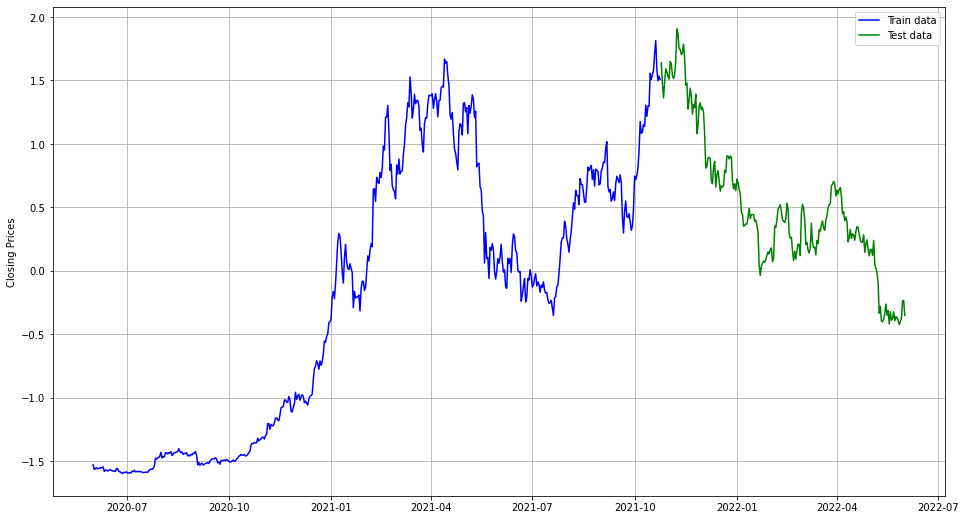

In [12]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'blue', label='Train data')
plt.plot(test_data['Close'], 'green', label='Test data')
plt.legend()




*   Gọi biến X <- Timestamp
*   Gọi biến y <- Close




In [13]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Close'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Close'].values.reshape(-1, 1)


In [14]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)

In [15]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

## Vẽ đồ thị cho tập test và kết quả dự đoán

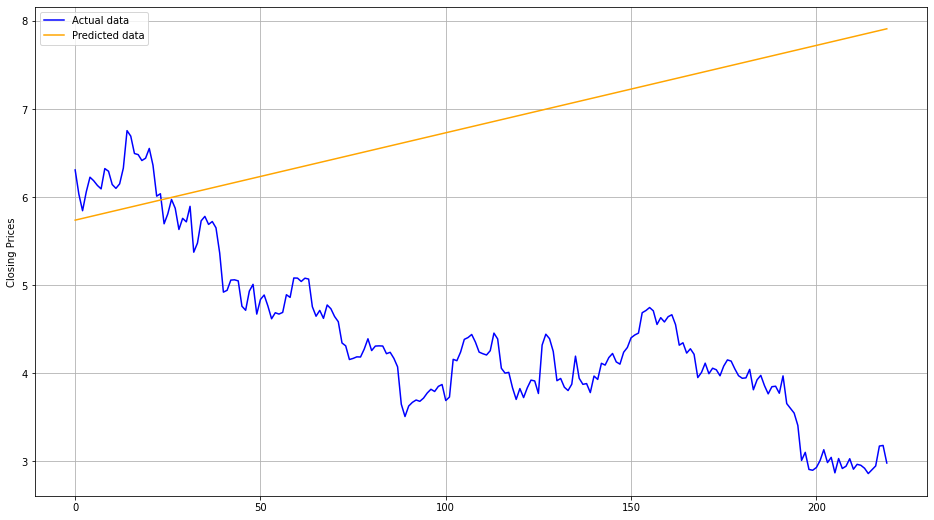

In [16]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


In [17]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.48
MAPE: 64.72%
MSE: 7.99
RMSE: 2.83
R2: -8.25


## Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình LR

In [18]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
Date,,,
2021-10-25,6.30670,5.736749,0.569951
2021-10-26,6.03108,5.746667,0.284413
2021-10-27,5.84381,5.756585,0.087225
2021-10-28,6.05825,5.766503,0.291747
2021-10-29,6.22428,5.776421,0.447859
...,...,...,...
2022-05-28,2.90271,7.869147,-4.966437
2022-05-29,2.94652,7.879065,-4.932545
2022-05-30,3.17233,7.888983,-4.716653


# 2. Quá trình dự đoán trên mô hình LSTM

## Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [19]:
df_lstm = df_pred.copy()
df_lstm

,Actual,Pred,Error
Date,,,
2021-10-25,6.30670,5.736749,0.569951
2021-10-26,6.03108,5.746667,0.284413
2021-10-27,5.84381,5.756585,0.087225
2021-10-28,6.05825,5.766503,0.291747
2021-10-29,6.22428,5.776421,0.447859
...,...,...,...
2022-05-28,2.90271,7.869147,-4.966437
2022-05-29,2.94652,7.879065,-4.932545
2022-05-30,3.17233,7.888983,-4.716653


## Vẽ đồ thị thể hiện sai số

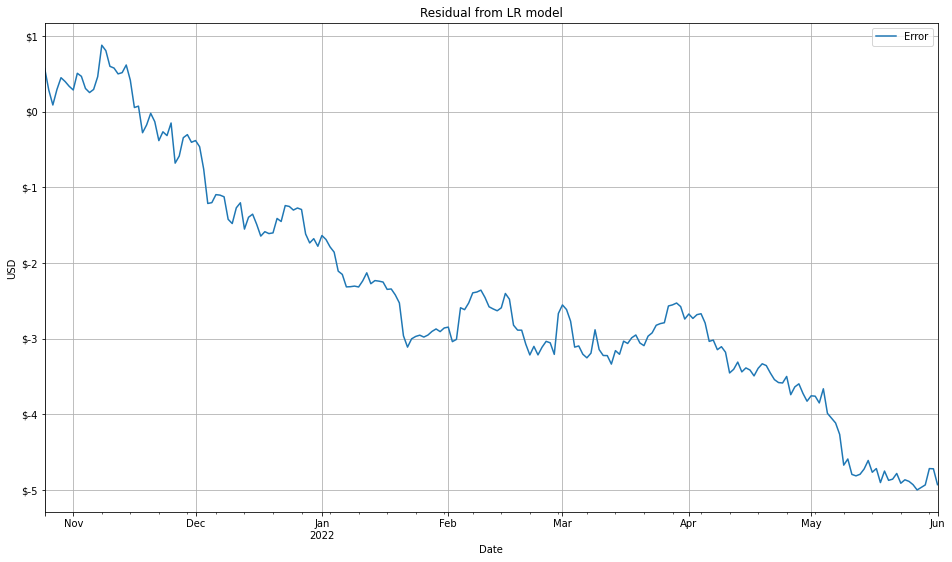

In [20]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from LR model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [21]:
error = np.array(error)
error

array([[ 0.56995147],
       [ 0.28441333],
       [ 0.0872252 ],
       [ 0.29174707],
       [ 0.44785893],
       [ 0.3976708 ],
       [ 0.33470267],
       [ 0.28535453],
       [ 0.5060764 ],
       [ 0.46583827],
       [ 0.30533014],
       [ 0.251582  ],
       [ 0.29262387],
       [ 0.46163574],
       [ 0.8771876 ],
       [ 0.80491947],
       [ 0.59782134],
       [ 0.5753132 ],
       [ 0.49817507],
       [ 0.51466694],
       [ 0.6157088 ],
       [ 0.41476067],
       [ 0.05396254],
       [ 0.0719144 ],
       [-0.27925373],
       [-0.17636186],
       [-0.02286   ],
       [-0.13310813],
       [-0.38357626],
       [-0.2670544 ],
       [-0.31712253],
       [-0.15070066],
       [-0.6810388 ],
       [-0.58745693],
       [-0.34481506],
       [-0.3044032 ],
       [-0.40551133],
       [-0.38268946],
       [-0.4640376 ],
       [-0.76040573],
       [-1.21395386],
       [-1.202842  ],
       [-1.09710013],
       [-1.10370826],
       [-1.1257564 ],
       [-1

In [22]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (217, 3, 1)
y_train (217, 1)


In [23]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin.h5")

Epoch 1/300
7/7 [==============================] - 3s 6ms/step - loss: 7.8433
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 7.3115
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 6.6376
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 5.6463
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 4.0482
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7067
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7304
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6705
Epoch 9/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4778
Epoch 10/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4053
Epoch 11/300
7/7 [==============================] - 0s 7ms/step - loss: 0.3034
Epoch 12/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2886
Epoch 13/300
7/7 [==============================] - 0s 6ms/st

In [24]:
model = load_model("bitcoin.h5")
error_pred = model.predict(x_train)
error_pred

array([[ 0.14700767],
       [ 0.3626253 ],
       [ 0.43854752],
       [ 0.37864134],
       [ 0.35557985],
       [ 0.32786837],
       [ 0.53849   ],
       [ 0.41800192],
       [ 0.3005967 ],
       [ 0.3080779 ],
       [ 0.34603694],
       [ 0.48683605],
       [ 0.8045614 ],
       [ 0.54595846],
       [ 0.4748936 ],
       [ 0.5807808 ],
       [ 0.45290747],
       [ 0.5087035 ],
       [ 0.5747302 ],
       [ 0.32804304],
       [ 0.06657522],
       [ 0.15457496],
       [-0.270718  ],
       [-0.16530818],
       [-0.13442066],
       [-0.19943547],
       [-0.3876216 ],
       [-0.33377823],
       [-0.43227088],
       [-0.2684716 ],
       [-0.72490513],
       [-0.6506674 ],
       [-0.4668577 ],
       [-0.41076288],
       [-0.51149774],
       [-0.49914542],
       [-0.5813903 ],
       [-0.8454838 ],
       [-1.241989  ],
       [-1.2636738 ],
       [-1.191376  ],
       [-1.2020144 ],
       [-1.2222499 ],
       [-1.4813771 ],
       [-1.5200211 ],
       [-1

In [25]:
df_lstm

,Actual,Pred,Error
Date,,,
2021-10-25,6.30670,5.736749,0.569951
2021-10-26,6.03108,5.746667,0.284413
2021-10-27,5.84381,5.756585,0.087225
2021-10-28,6.05825,5.766503,0.291747
2021-10-29,6.22428,5.776421,0.447859
...,...,...,...
2022-05-28,2.90271,7.869147,-4.966437
2022-05-29,2.94652,7.879065,-4.932545
2022-05-30,3.17233,7.888983,-4.716653


In [26]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,Pred,Error,Error Prediction
Date,,,,
2021-10-25,6.30670,5.736749,0.569951,0.147008
2021-10-26,6.03108,5.746667,0.284413,0.362625
2021-10-27,5.84381,5.756585,0.087225,0.438548
2021-10-28,6.05825,5.766503,0.291747,0.378641
2021-10-29,6.22428,5.776421,0.447859,0.355580
...,...,...,...,...
2022-05-25,2.95406,7.839393,-4.885333,-5.105225
2022-05-26,2.92035,7.849311,-4.928961,-5.089567
2022-05-27,2.86012,7.859229,-4.999109,-5.066911


In [27]:
df_lstm['LR_LSTM'] = df_lstm['Pred'] + df_lstm['Error Prediction']
df_lstm

,Actual,Pred,Error,Error Prediction,LR_LSTM
Date,,,,,
2021-10-25,6.30670,5.736749,0.569951,0.147008,5.883756
2021-10-26,6.03108,5.746667,0.284413,0.362625,6.109292
2021-10-27,5.84381,5.756585,0.087225,0.438548,6.195132
2021-10-28,6.05825,5.766503,0.291747,0.378641,6.145144
2021-10-29,6.22428,5.776421,0.447859,0.355580,6.132001
...,...,...,...,...,...
2022-05-25,2.95406,7.839393,-4.885333,-5.105225,2.734168
2022-05-26,2.92035,7.849311,-4.928961,-5.089567,2.759744
2022-05-27,2.86012,7.859229,-4.999109,-5.066911,2.792318


## Vẽ đồ thị

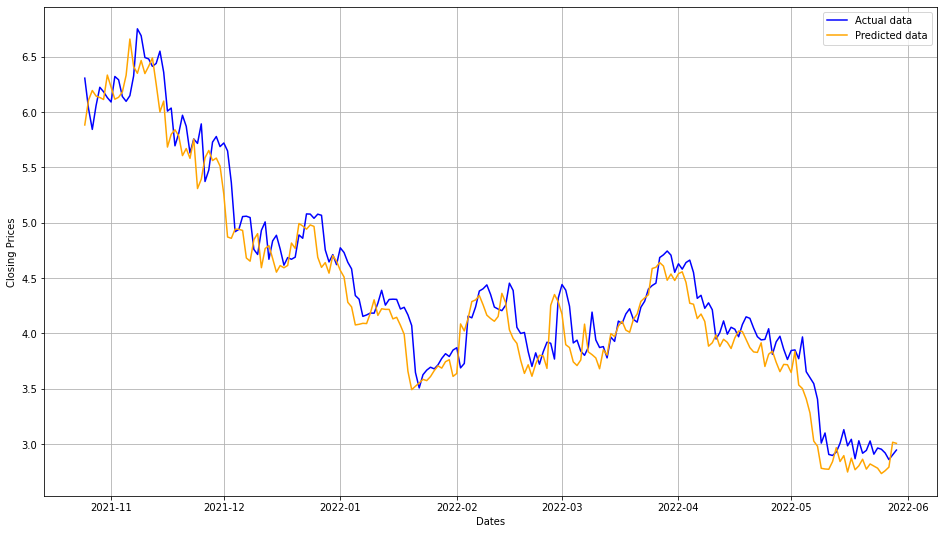

In [28]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['LR_LSTM'], 'orange', label='Predicted data')
plt.legend()

## Đánh giá mô hình

In [29]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_lstm.Actual, df_lstm.LR_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.LR_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.LR_LSTM)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.18
MAPE: 4.15%
MSE: 0.05
RMSE: 0.23
R2: -8.25


## Lấy 3 ngày cuối ra để dự báo

In [30]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -4.999109
2022-05-28   -4.966437
2022-05-29   -4.932545
Name: Error, dtype: float64

## Đưa về ma trận

In [31]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-4.99910905],
        [-4.96643718],
        [-4.93254532]]])

In [32]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

array([-5.0669107], dtype=float32)

## So sánh kết quả dự đoán với giá trị thực

In [33]:
y_LR = df_pred.copy()
y_LR = y_LR.tail(4).head(1)
y_LR

,Actual,Pred,Error
Date,,,
2022-05-29,2.94652,7.879065,-4.932545


In [34]:
y_LR['Final_LSTM'] = y_LR.Pred + y_forecast
y_LR

,Actual,Pred,Error,Final_LSTM
Date,,,,
2022-05-29,2.94652,7.879065,-4.932545,2.812155


## Ghi ra file csv

In [35]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("LR-PRED.csv")
df_lstm.to_csv("LSTM_PRED.csv")
y_LR.to_csv("Forecast.csv")